(200, 2) (200, 1)


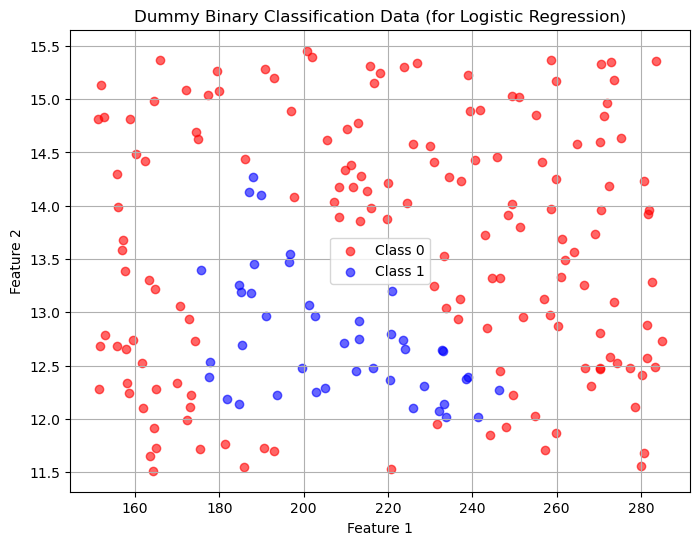

In [1]:
import numpy as np
from matplotlib import pyplot as plt

def load_coffee_data():
    """ Creates a coffee roasting data set.
        roasting duration: 12-15 minutes is best
        temperature range: 175-260C is best
    """
    rng = np.random.default_rng(2)
    x = rng.random(400).reshape(-1,2)
    x[:,1] = x[:,1] * 4 + 11.5          # 12-15 min is best
    x[:,0] = x[:,0] * (285-150) + 150  # 350-500 F (175-260 C) is best
    Y = np.zeros(len(x))
    
    i=0
    for t,d in x:
        y = -3/(260-175)*t + 21
        if (t > 175 and t < 260 and d > 12 and d < 15 and d<=y ):
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1

    return (x, Y.reshape(-1,1))

x,y = load_coffee_data()
print(x.shape, y.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x[y.flatten() == 0][:, 0], x[y.flatten() == 0][:, 1], color="red", label="Class 0", alpha=0.6)
plt.scatter(x[y.flatten() == 1][:, 0], x[y.flatten() == 1][:, 1], color="blue", label="Class 1", alpha=0.6)
plt.title("Dummy Binary Classification Data (for Logistic Regression)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

In [77]:
y[y==0]=-1
y = y.ravel()
# x_mean = np.mean(x)
# x_std = np.std(x)
# x = (x-x_mean)/x_std

11195138463.653473


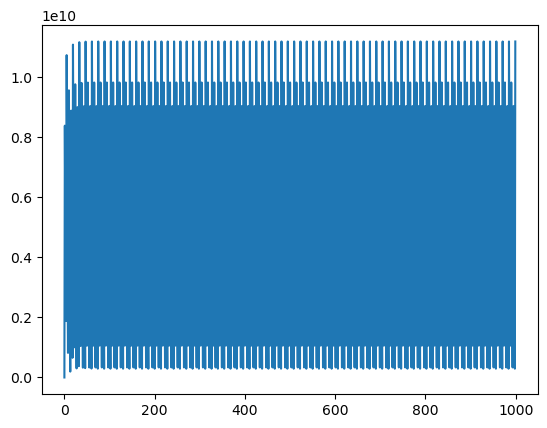

In [78]:
m = x.shape[0]
lr = 0.1
np.random.seed(0)
w = np.zeros(m)
b = 0
c = 10
epochs = 1000
cost =[]
def polykernel(x,r=1.0,degree = 3):
    return (np.dot(x,x.T)+r)**degree
k = polykernel(x,r=1.0,degree=3)
for epoch in range(epochs):
    y_pred= w@k+b
    hinge = np.maximum(0,1-(y*y_pred))
    cst = 0.5*np.dot(w,w) + c*np.sum(hinge)
    cost.append(cst)
    violated = (y * y_pred) < 1
    dw = w - c * np.dot(k.T, violated * y)  # Fixed gradient
    db = -c * np.sum(y[violated])

    w -= lr*dw
    b -= lr*db 
print(cost[-1])
plt.plot(cost)

Training accuracy: 85.50%


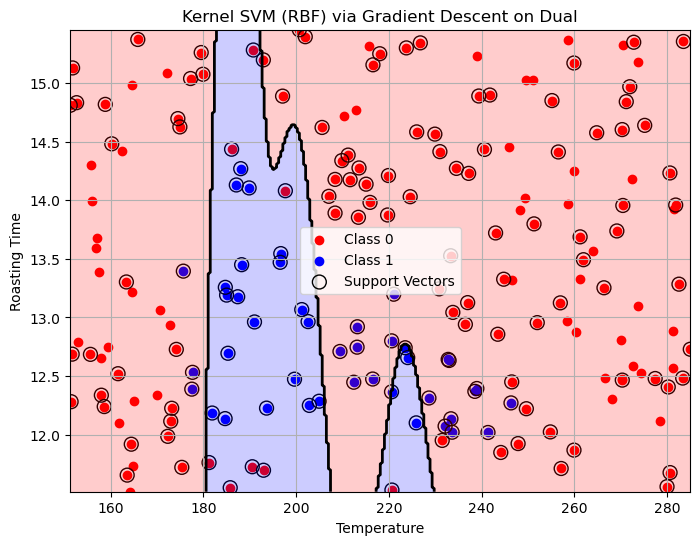

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
def load_coffee_data():
    rng = np.random.default_rng(2)
    x = rng.random(400).reshape(-1, 2)
    x[:, 1] = x[:, 1] * 4 + 11.5
    x[:, 0] = x[:, 0] * (285 - 150) + 150
    Y = np.zeros(len(x))
    for i, (t, d) in enumerate(x):
        y = -3 / (260 - 175) * t + 21
        if 175 < t < 260 and 12 < d < 15 and d <= y:
            Y[i] = 1
        else:
            Y[i] = 0
    return x, Y.reshape(-1, 1)

# Kernel function: RBF
def rbf_kernel(X1, X2, sigma=5.0):
    X1_sq = np.sum(X1**2, axis=1).reshape(-1, 1)
    X2_sq = np.sum(X2**2, axis=1).reshape(1, -1)
    dist_sq = X1_sq + X2_sq - 2 * np.dot(X1, X2.T)
    return np.exp(-dist_sq / (2 * sigma**2))

# Gradient ascent on dual
def train_kernel_svm(X, y, C=1.0, sigma=5.0, epochs=1000, lr=0.001):
    n = X.shape[0]
    y = y.flatten()
    K = rbf_kernel(X, X, sigma)
    alphas = np.zeros(n)

    for epoch in range(epochs):
        for i in range(n):
            grad = 1 - np.sum(alphas * y * y[i] * K[:, i])
            alphas[i] += lr * grad
            # Clip to [0, C]
            alphas[i] = np.clip(alphas[i], 0, C)

        # Project alphas to satisfy constraint: sum(alpha_i * y_i) = 0
        alpha_y = alphas * y
        alpha_y -= np.mean(alpha_y)  # Centering to enforce sum ~= 0
        alphas = alpha_y * y

    # Support vectors
    sv = alphas > 1e-5
    return alphas, X[sv], y[sv], alphas[sv], K, sv

# Prediction
def project(X_train, y_train, alphas, X_sv, y_sv, alpha_sv, sigma, b):
    K = rbf_kernel(X_train, X_sv, sigma)
    return np.dot(K, alpha_sv * y_sv) + b

def predict(X_test, X_sv, y_sv, alpha_sv, sigma, b):
    K = rbf_kernel(X_test, X_sv, sigma)
    return np.sign(np.dot(K, alpha_sv * y_sv) + b)

# Load and preprocess
X, y = load_coffee_data()
y = y * 2 - 1  # Convert to {-1, 1}

# Train kernel SVM
alphas, X_sv, y_sv, alpha_sv, K, sv_mask = train_kernel_svm(X, y, sigma=5.0, epochs=500, lr=0.005)

# Estimate bias using any support vector
b = y_sv[0] - np.sum(alpha_sv * y_sv * rbf_kernel(X_sv, X_sv[0:1], sigma=5.0).flatten())

# Predict
y_pred = predict(X, X_sv, y_sv, alpha_sv, sigma=5.0, b=b)
accuracy = np.mean(y_pred == y.flatten())
print(f"Training accuracy: {accuracy * 100:.2f}%")

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(X[y.flatten() == -1][:, 0], X[y.flatten() == -1][:, 1], color='red', label='Class 0')
plt.scatter(X[y.flatten() == 1][:, 0], X[y.flatten() == 1][:, 1], color='blue', label='Class 1')
plt.scatter(X_sv[:, 0], X_sv[:, 1], s=100, facecolors='none', edgecolors='k', label='Support Vectors')

# Decision boundary
xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 300),
                     np.linspace(X[:, 1].min(), X[:, 1].max(), 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = predict(grid, X_sv, y_sv, alpha_sv, sigma=5.0, b=b).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, levels=[-1, 0, 1], colors=['red', 'blue'])
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='k')

plt.title("Kernel SVM (RBF) via Gradient Descent on Dual")
plt.xlabel("Temperature")
plt.ylabel("Roasting Time")
plt.legend()
plt.grid(True)
plt.show()


Epoch 0, Loss: 283.7519
Epoch 100, Loss: 96.3608
Epoch 200, Loss: 94.8892
Epoch 300, Loss: 96.6408
Epoch 400, Loss: 95.5808
Epoch 500, Loss: 97.6476
Epoch 600, Loss: 87.1217
Epoch 700, Loss: 106.3068
Epoch 800, Loss: 103.1754
Epoch 900, Loss: 108.6948
Final Accuracy: 78.0 %


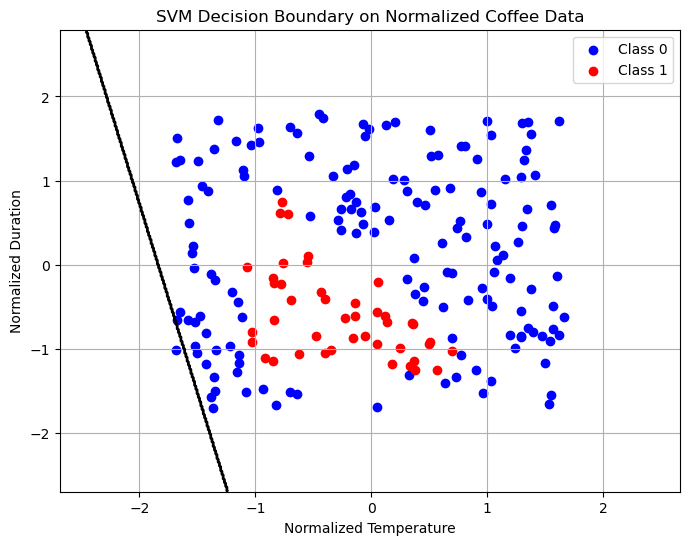

93.44202539744178


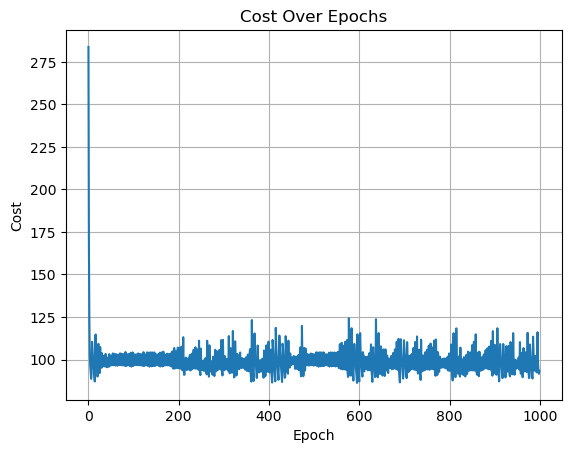

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
def load_coffee_data():
    rng = np.random.default_rng(2)
    X = rng.random(400).reshape(-1, 2)
    X[:, 1] = X[:, 1] * 4 + 11.5
    X[:, 0] = X[:, 0] * (285 - 150) + 150
    Y = np.zeros(len(X))
    for i, (t, d) in enumerate(X):
        y = -3/(260-175)*t + 21
        Y[i] = 1 if (175 < t < 260 and 12 < d < 15 and d <= y) else 0
    return X, Y.reshape(-1, 1)

# Load and normalize
X, y = load_coffee_data()
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std
y = y * 2 - 1  # Convert labels to {-1, 1}

# Initialize
W = np.random.randn(2, 1)
b = 0.0
C = 1.0
lr = 0.01
epochs = 1000
costs = []

# Train using gradient descent
for epoch in range(epochs):
    margin = y * (X_norm @ W + b)
    loss = 0.5 * np.sum(W**2) + C * np.sum(np.maximum(0, 1 - margin))
    indicator = (margin < 1).astype(float)
    dW = W - C * (X_norm.T @ (indicator * y))
    db = -C * np.sum(indicator * y)
    W -= lr * dW
    b -= lr * db
    costs.append(loss)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Prediction
y_pred = np.sign(X_norm @ W + b)
acc = np.mean(y_pred.flatten() == y.flatten())
print("Final Accuracy:", acc * 100, "%")

# 🔲 Decision Boundary Plot
xx, yy = np.meshgrid(
    np.linspace(X_norm[:, 0].min() - 1, X_norm[:, 0].max() + 1, 500),
    np.linspace(X_norm[:, 1].min() - 1, X_norm[:, 1].max() + 1, 500)
)
grid = np.c_[xx.ravel(), yy.ravel()]
Z = np.sign(grid @ W + b).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contour(xx, yy, Z, levels=[0], colors='k', linewidths=2)
plt.scatter(X_norm[y[:, 0] == -1][:, 0], X_norm[y[:, 0] == -1][:, 1], color='blue', label='Class 0')
plt.scatter(X_norm[y[:, 0] == 1][:, 0], X_norm[y[:, 0] == 1][:, 1], color='red', label='Class 1')
plt.title("SVM Decision Boundary on Normalized Coffee Data")
plt.xlabel("Normalized Temperature")
plt.ylabel("Normalized Duration")
plt.legend()
plt.grid(True)
plt.show()

# 🔳 Cost plot
print(costs[-1])
plt.plot(costs)
plt.title("Cost Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

Epoch 0, Loss: 268.7267
Epoch 100, Loss: 43.3777
Epoch 200, Loss: 43.1839
Epoch 300, Loss: 43.2211
Epoch 400, Loss: 43.2340
Epoch 500, Loss: 43.2086
Epoch 600, Loss: 43.1888
Epoch 700, Loss: 43.2184
Epoch 800, Loss: 43.1826
Epoch 900, Loss: 43.2308
Final Accuracy: 94.5 %


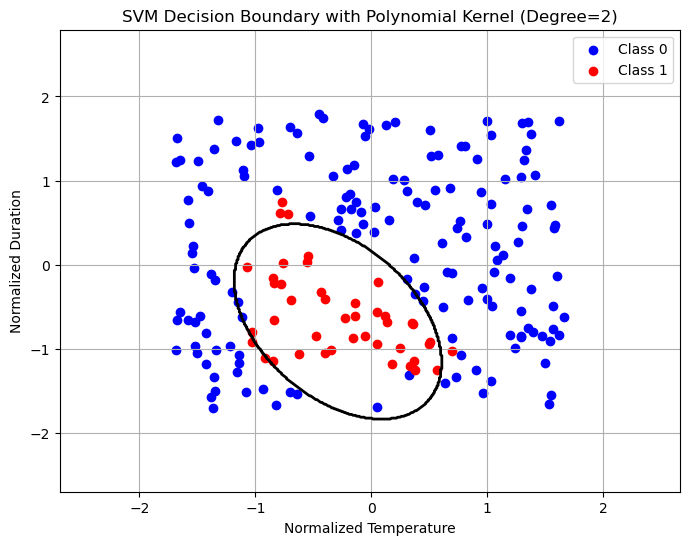

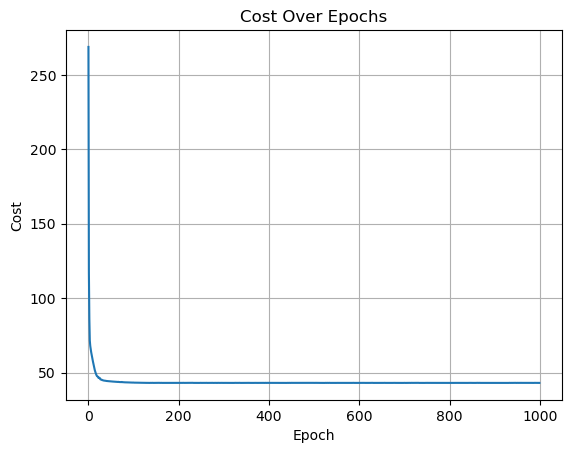

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
def load_coffee_data():
    rng = np.random.default_rng(2)
    X = rng.random(400).reshape(-1, 2)
    X[:, 1] = X[:, 1] * 4 + 11.5
    X[:, 0] = X[:, 0] * (285 - 150) + 150
    Y = np.zeros(len(X))
    for i, (t, d) in enumerate(X):
        y = -3/(260-175)*t + 21
        Y[i] = 1 if (175 < t < 260 and 12 < d < 15 and d <= y) else 0
    return X, Y.reshape(-1, 1)

# Polynomial feature expansion for degree 2
def polynomial_features(X):
    x1 = X[:, 0].reshape(-1, 1)
    x2 = X[:, 1].reshape(-1, 1)
    x1_sq = x1 ** 2
    x2_sq = x2 ** 2
    x1_x2 = x1 * x2
    return np.hstack([x1, x2, x1_sq, x2_sq, x1_x2])

# Load and normalize
X, y = load_coffee_data()
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std
y = y * 2 - 1  # Convert labels to {-1, 1}

# Apply polynomial feature expansion
X_poly = polynomial_features(X_norm)

# Initialize
W = np.random.randn(X_poly.shape[1], 1)
b = 0.0
C = 1.0
lr = 0.01
epochs = 1000
costs = []

# Training loop
for epoch in range(epochs):
    margin = y * (X_poly @ W + b)
    loss = 0.5 * np.sum(W**2) + C * np.sum(np.maximum(0, 1 - margin))
    indicator = (margin < 1).astype(float)
    dW = W - C * (X_poly.T @ (indicator * y))
    db = -C * np.sum(indicator * y)
    W -= lr * dW
    b -= lr * db
    costs.append(loss)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Prediction
y_pred = np.sign(X_poly @ W + b)
acc = np.mean(y_pred.flatten() == y.flatten())
print("Final Accuracy:", acc * 100, "%")

# Decision boundary plotting
xx, yy = np.meshgrid(
    np.linspace(X_norm[:, 0].min() - 1, X_norm[:, 0].max() + 1, 500),
    np.linspace(X_norm[:, 1].min() - 1, X_norm[:, 1].max() + 1, 500)
)
grid = np.c_[xx.ravel(), yy.ravel()]
grid_poly = polynomial_features(grid)
Z = np.sign(grid_poly @ W + b).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contour(xx, yy, Z, levels=[0], colors='k', linewidths=2)
plt.scatter(X_norm[y[:, 0] == -1][:, 0], X_norm[y[:, 0] == -1][:, 1], color='blue', label="Class 0")
plt.scatter(X_norm[y[:, 0] == 1][:, 0], X_norm[y[:, 0] == 1][:, 1], color='red', label="Class 1")
plt.title("SVM Decision Boundary with Polynomial Kernel (Degree=2)")
plt.xlabel("Normalized Temperature")
plt.ylabel("Normalized Duration")
plt.legend()
plt.grid(True)
plt.show()

# Cost plot
plt.plot(costs)
plt.title("Cost Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.grid(True)
plt.show()